In [112]:
'''
和吴恩达老师不同，这里的数据是行向量的，即每列表示对应的特征，行表示由多少个数据
'''
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import h5py

In [2]:
def unpickle(filename):  #解pickle数据
    import pickle
    with open(filename, 'rb') as f:
        dataSet = pickle.load(f, encoding = 'bytes')
    return dataSet

def splitData(dataSet):
    trainSet = dataSet[b'data']
    trainLabel = dataSet[b'labels']
    return trainSet, np.mat(trainLabel).T

def visualSomeImage(trainSet, trainLabel, labelNames):  #可视化部分图形
    trainLabel = np.array(trainLabel)
    numClass = len(labelNames)
    sample_per_class = 7   #在一张图片里可视化7x10
    for y, cls in enumerate(labelNames):
        idxs = np.flatnonzero(trainLabel == y)
        idxs = np.random.choice(idxs, sample_per_class, replace = False)
        for i, idx in enumerate(idxs):
            plt_idx = i * numClass + y + 1
            plt.subplot(sample_per_class, numClass, plt_idx)
            image = trainSet[idx].reshape(3, 32, 32).transpose(1, 2, 0).astype('float')
            plt.imshow(image.astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
                

def get_All_Data():  #加载图片数据集，并且划分为训练集和测试集（首先并没有划分dev集）
    trainFile1 = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\data_batch_1'  #其中之一的训练集
    trainFile2 = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\data_batch_2'  #其中之一的训练集
    trainFile3 = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\data_batch_3'  #其中之一的训练集
    trainFile4 = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\data_batch_4'  #其中之一的训练集
    trainFile5 = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\data_batch_5'  #其中之一的训练集
    labelFile = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\batches.meta'  #返回的的是下标的英文名字
    testFile = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\test_batch'  #测试集合

    dataSet = unpickle(trainFile1)  #首先使用的是一个数据集，看看效果
    trainSet1, trainLabel1 = splitData(dataSet)   #训练集
    dataSet = unpickle(trainFile2)  
    trainSet2, trainLabel2 = splitData(dataSet)   #训练集
    dataSet = unpickle(trainFile3)  
    trainSet3, trainLabel3 = splitData(dataSet)   #训练集
    dataSet = unpickle(trainFile4)  
    trainSet4, trainLabel4 = splitData(dataSet)   #训练集
    dataSet = unpickle(trainFile5)  
    trainSet5, trainLabel5 = splitData(dataSet)   #训练集

    trainSet = np.concatenate((trainSet1, trainSet2), axis = 0)
    trainLabel = np.concatenate((trainLabel1, trainLabel2), axis = 0)
    dataSet = unpickle(testFile)
    testSet, testLabel = splitData(dataSet)  #测试集
    
    #随机选取1000张图片作测试，看准确度
    '''
    randIndex = np.random.permutation(10000)
    shuffled_X = testAllSet[randIndex, :]
    shuffled_Y = testAllLabel[randIndex, :]
    testSet = shuffled_X[:1000, :]   #随机取1000个数据集作为测试
    testLabel = shuffled_Y[:1000, :]
    '''
    label = unpickle(labelFile)  
    labelNames = label[b'label_names'] #label的名字,例如'cat'
    #visualSomeImage(trainSet, trainLabel, labelNames)  #可视化

    #normlization
    trainSet, testSet = trainSet.astype(float), testSet.astype(float)
    mean_image = np.mean(trainSet, axis = 0)
    trainSet -= np.mat(mean_image)
    testSet -= mean_image

    return trainSet1, trainLabel1, testSet, testLabel, labelNames
    
def miniBatch(trainSet, trainLabel,  batchSize = 256):  #将训练数据划分为minibatch，然后进行训练
    m = trainSet.shape[0] #训练集的总数
    mini_batches = []  #划分训练集存储的地方

    #先打乱顺序，然后再mini-batch
    randIndex = np.random.permutation(m)
    shuffled_X = trainSet[randIndex, :]
    shuffled_Y = trainLabel[randIndex, :]

    num_complete_minibatches = int(m/batchSize)
    for k in range(num_complete_minibatches):
        minibatch_X = shuffled_X[k*batchSize : (k+1)*batchSize, :]
        minibatch_Y = shuffled_Y[k*batchSize : (k+1)*batchSize, :]
        minibatch = (minibatch_X, minibatch_Y)
        mini_batches.append(minibatch)

    if m % batchSize != 0:  #如果数据不是minibatch的整数倍，对剩下的单独处理
        minibatch_X = shuffled_X[num_complete_minibatches*batchSize:, :]
        minibatch_Y = shuffled_Y[num_complete_minibatches*batchSize:, :]
        mini_batches.append((minibatch_X, minibatch_Y))

    return mini_batches

def convert_to_one_hot(Y, C):  #将标签变为数量乘以10（这里有10类）
    Y = np.eye(C)[Y].T
    return Y

In [152]:
def load_dataset():  #吴恩达老师的手势数据集
    train_dataset = h5py.File(r'E:\jupyter notebook\finger_sign_dataSet\train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(r'E:\jupyter notebook\finger_sign_dataSet\test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [155]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()
trainSet, testSet = train_set_x_orig/255, test_set_x_orig/255
train_set_y_orig = np.array(list(map(int, train_set_y_orig.reshape(-1, 1))))
test_set_y_orig = np.array(list(map(int, test_set_y_orig.reshape(-1, 1))))
trainLabel = convert_to_one_hot(train_set_y_orig, 6).T
testLabel = convert_to_one_hot(test_set_y_orig, 6).T
m = trainLabel.shape[0]

In [198]:

trainFile1 = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\data_batch_1'  #其中之一的训练集
labelFile = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\batches.meta'  #返回的的是下标的英文名字

dataSet = unpickle(trainFile1)  #首先使用的是一个数据集，看看效果
trainSet, trainLabel = splitData(dataSet)   #训练集
label = unpickle(labelFile)  
labelNames = label[b'label_names'] #label的名字,例如'cat'

testFile = r'F:\数据集\斯坦福大学数据集\cifar-10-python\cifar-10-batches-py\test_batch'  #测试集合
dataSet = unpickle(testFile)  #首先使用的是一个数据集，看看效果
testSet, testLabel = splitData(dataSet)   #训练集
m = trainSet.shape[0]

trainSet = trainSet.reshape(m, 3, 32, 32).transpose(0, 2, 3, 1)/255  #将数据变为图片形式，然后输入训练,记住需要归一化
trainLabel = np.array(list(map(int, trainLabel)))
trainLabel = convert_to_one_hot(trainLabel, 10).T

testSet = testSet.reshape(m, 3, 32, 32).transpose(0, 2, 3, 1)/255  #将数据变为图片形式，然后输入训练,记住需要归一化
testLabel = np.array(list(map(int, testLabel)))
testLabel = convert_to_one_hot(testLabel, 10).T

In [156]:
def create_placeholder(n_H, n_W, n_C, n_y):  #创建tensorflow的placeholder
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y


In [201]:

def initialize_parameters():  #这里采用的是固定的filter，然后进行运算，我采用2层卷积网络
    """
    W1 = [4, 4, 3, 8]
    W2 = [2, 2, 8, 16]
    W3 = [2, 2, 16, 32]
    """
    W1 = tf.get_variable('W1', [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2', [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable('W3', [2, 2, 16, 32], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {'W1':W1,
                 'W2':W2,
                 'W3':W3}
    
    return parameters

In [202]:
def forward_propagation(X, parameters):  #前向传播
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    Z1 = tf.nn.conv2d(X, W1, strides = (1, 1, 1, 1), padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = (1, 4, 4, 1), strides = (1, 4, 4, 1), padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides = (1, 1, 1, 1), padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = (1, 2, 2, 1), strides = (1, 2, 2, 1), padding = 'SAME')

    Z3 = tf.nn.conv2d(P2, W3, strides = (1, 1, 1, 1), padding = 'SAME')
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize = (1, 2, 2 ,1), strides = (1, 2, 2, 1), padding = 'SAME')

    P3 = tf.contrib.layers.flatten(P3)
    
    Z4 = tf.contrib.layers.fully_connected(P3, 10, activation_fn = None)
    
    return Z4
    

In [203]:
def compute_loss(Z4, Y):  #计算损失
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y)) #x这里的Z4一定要是原始的，因为这里的函数有softmax
    return loss

In [204]:
def model(trainSet, trainLabel, learning_rate = 0.009, num_epochs = 100, minibatch_size = 256):#融合模型
    ops.reset_default_graph()  
    
    m, n_H, n_W, n_C = trainSet.shape
    n_y = trainLabel.shape[1]
    costs = []  #存储总的cost，来画图
    
    X, Y = create_placeholder(n_H, n_W, n_C, n_y)
    
    parameters = initialize_parameters()
    
    Z4 = forward_propagation(X, parameters)
    loss = compute_loss(Z4, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            minibatches = miniBatch(trainSet, trainLabel, batchSize = minibatch_size)
            for minibatch in minibatches:
                minibatch_X, minibatch_Y = minibatch
                _ , temp_cost = sess.run([optimizer, loss], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost/num_minibatches
                
            if epoch % 5 == 0:
                print('after epoch %d, loss is %f' %(epoch, minibatch_cost))
            if epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        saver = tf.train.Saver()
        save_path = saver.save(sess, 'E:/jupyter notebook/store_model/save_net.ckpt')
        '''
        predict_op = tf.argmax(Z4, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #print(accuracy)
        train_accuracy = accuracy.eval({X: trainSet, Y: trainLabel})
        print("Train Accuracy:", train_accuracy)     
        '''

after epoch 0, loss is 2.180498
after epoch 5, loss is 1.610578
after epoch 10, loss is 1.490229
after epoch 15, loss is 1.407680
after epoch 20, loss is 1.342103
after epoch 25, loss is 1.287238
after epoch 30, loss is 1.250521
after epoch 35, loss is 1.206639
after epoch 40, loss is 1.186369
after epoch 45, loss is 1.149575
after epoch 50, loss is 1.134303
after epoch 55, loss is 1.102972
after epoch 60, loss is 1.086617
after epoch 65, loss is 1.066568
after epoch 70, loss is 1.047632
after epoch 75, loss is 1.040087
after epoch 80, loss is 1.019918
after epoch 85, loss is 1.006820
after epoch 90, loss is 1.001028
after epoch 95, loss is 0.988559


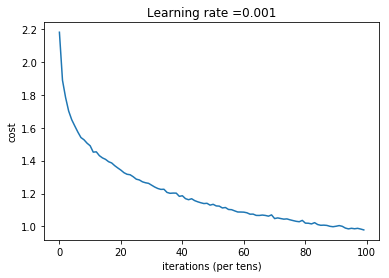

In [205]:
model(trainSet, trainLabel, learning_rate = 0.001, num_epochs = 100, minibatch_size = 64)

In [194]:
def predSelf(testSet, testLabel = None):  #预测，存储之后的值进行预测
    ops.reset_default_graph()
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)

        parameters = initialize_parameters()
        (m, n_H0, n_W0, n_C0) = testSet.shape  
        n_y = testLabel.shape[1]                            
        X, Y = tf.placeholder(tf.float32, [None,  n_H0, n_W0, n_C0]), tf.placeholder(tf.float32, [None, n_y])
        Z4 = forward_propagation(X, parameters)

        # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
        #optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

        saver = tf.train.Saver()
        saver.restore(sess, 'E:/jupyter notebook/store_model/save_net.ckpt')

        predict_op = tf.argmax(Z4, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #print(accuracy)
        train_accuracy = accuracy.eval({X: testSet, Y: testLabel})
        print("Test Accuracy:", train_accuracy)   

In [207]:
#testSet.shape
#predSelf(trainSet, trainLabel)
predSelf(testSet[:1000], testLabel[:1000])

INFO:tensorflow:Restoring parameters from E:/jupyter notebook/store_model/save_net.ckpt
Test Accuracy: 0.537




之前没有归一化，各种错误。。。梯度不下降了。。记住归一化的重要性



In [41]:
tf.reset_default_graph()  #这个一定要，不然就会出现什么重复出现什么的
with tf.Session() as sess:  #最好用这种情形吧，可以使用eval()
    parameters = initialize_parameters()   #参数要在Init上面，不然未定义
    X, Y = create_placeholder(32, 32, 3, 10)
    Z3 = forward_propagation(X, parameters)
    loss = compute_loss(Z3,Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    print(sess.run(loss, feed_dict = {X:np.random.randn(4, 32, 32, 3), Y:np.random.randn(4, 10)}))

1.15411
